# Solution Notebook for Booking.com Challenge
**Advanced Topics in Recommendation Systems Course**

**Ben-Gurion University of the Negev**

This notebook presents the solution developed by the **YankeLevi Insights** team for the Booking.com kaggle challenge.

**Submitters**: Yarin Yerushalmi Levi 316141407 and Idan Yankelev 315851824.

## Imports

In [1]:
import pandas as pd
import os
import calendar
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import numpy as np

In [6]:
!unzip /content/booking-challenge.zip

Archive:  /content/booking-challenge.zip
  inflating: test_reviews.csv        
  inflating: test_users.csv          
  inflating: train_matches.csv       
  inflating: train_reviews.csv       
  inflating: train_users.csv         
  inflating: val_matches.csv         
  inflating: val_reviews.csv         
  inflating: val_users.csv           


## Preprocessing The Data

In the following cell, we define the user context generation function, which transforms the user's tabular features into a cohesive representation of their vacation context.

In [7]:
def generate_user_context(user_data):
    """
    Generate a user context string based on user data for matching with potential hotel reviews.

    Parameters:
    user_data (dict): Dictionary containing the user's features.

    Returns:
    str: Generated user context.
    """

    # Extract user details and handle edge cases
    guest_type = str(user_data.get('guest_type', 'unknown')).strip().lower()
    guest_country = str(user_data.get('guest_country', 'unknown')).strip().lower()
    room_nights = str(user_data.get('room_nights', 'unknown')).strip().lower()
    month_name = str(user_data.get('month', 'unknown')).strip().lower()
    accommodation_type = str(user_data.get('accommodation_type', 'unknown')).strip().lower()
    accommodation_country = str(user_data.get('accommodation_country', 'unknown')).strip().lower()
    location_is_ski = str(user_data.get('location_is_ski', '0')).strip().lower()
    location_is_beach = str(user_data.get('location_is_beach', '0')).strip().lower()
    location_is_city_center = str(user_data.get('location_is_city_center', '0')).strip().lower()
    accommodation_score = str(user_data.get('accommodation_score', 'unknown')).strip().lower()
    accommodation_star_rating = str(user_data.get('accommodation_star_rating', 'unknown')).strip().lower()

    # Parse month name
    if month_name.isdigit():
        try:
            month_name = calendar.month_name[int(month_name)]
        except (ValueError, IndexError):
            month_name = "unknown"

    # Construct user context
    context_parts = []

    # Guest type and country
    if guest_type == "solo traveller":
        context_parts.append(
            f"I visited {accommodation_country if accommodation_country != 'unknown' else 'the accommodation'} alone")
    elif guest_type == "unknown":
        context_parts.append(
            f"Visited {accommodation_country if accommodation_country != 'unknown' else 'the accommodation'}")
    elif guest_type == "couple":
        context_parts.append(
            f"We visited {accommodation_country if accommodation_country != 'unknown' else 'the accommodation'} as a couple")
    else:
        context_parts.append(
            f"We visited {accommodation_country if accommodation_country != 'unknown' else 'the accommodation'} as a family")

    if guest_country != "unknown":
        context_parts.append(f"from {guest_country}")

    # Duration of stay
    if room_nights.isdigit():
        days = int(room_nights) + 1
        context_parts.append(f"for {days} days and {room_nights} nights")

    # Time of visit
    if month_name != "unknown":
        context_parts.append(f"during {month_name}")

    # Accommodation details
    if accommodation_type != "unknown":
        context_parts.append(f"and stayed at a {accommodation_type}")
    if accommodation_star_rating.isdigit() and accommodation_star_rating != "unknown":
        context_parts.append(f"with a {accommodation_star_rating}-star rating")
    if accommodation_score.isdigit() and accommodation_score != "unknown":
        context_parts.append(f"scoring {accommodation_score}/10")

    # Location highlights
    location_details = []
    if location_is_ski == "1":
        location_details.append("near a ski area")
    if location_is_beach == "1":
        location_details.append("close to the beach")
    if location_is_city_center == "1":
        location_details.append("in a central location near the city center")

    if location_details:
        context_parts.append(f"located {' and '.join(location_details)}")

    # Final punctuation and return
    context = ". ".join(context_parts).strip() + "."
    return context.capitalize()

In the following cell, we define the review context generation function, which transforms the review's tabular features into a cohesive representation of the user's experience context.

In [8]:
def generate_review_context(review_data):
    """
    Generate a text summary of a review based on review data.

    Parameters:
    review_data (dict): Dictionary containing the review features as strings.

    Returns:
    str: Generated review context.
    """

    # Extract review details, handling missing data
    review_title = str(review_data.get('review_title', 'No title provided')).strip().lower()
    review_positive = str(review_data.get('review_positive', 'No positive feedback provided')).strip().lower()
    review_negative = str(review_data.get('review_negative', 'No negative feedback provided')).strip().lower()
    review_score = str(review_data.get('review_score', 'unknown')).strip().lower()
    review_helpful_votes = str(review_data.get('review_helpful_votes', '0')).strip().lower()

    # Ensure helpful votes is numeric for logic
    try:
        helpful_votes = int(review_helpful_votes)
    except ValueError:
        helpful_votes = 0  # Default to 0 if conversion fails

    # Build the review context
    context_parts = []

    # Review title
    if review_title and review_title != "no title provided":
        context_parts.append(f'Review titled: "{review_title}".')
    else:
        context_parts.append(f"No title provided.")

    # Positive feedback
    if review_positive and review_positive != "no positive feedback provided":
        context_parts.append(f"Positive feedback: {review_positive}.")
    else:
        context_parts.append(f"no positive feedback provided.")

    # Negative feedback
    if review_negative and review_negative != "no negative feedback provided":
        context_parts.append(f"Negative feedback: {review_negative}.")
    else:
        context_parts.append(f"No negative feedback provided.")

    # Review score
    if review_score.isdigit():
        context_parts.append(f"The review gave a score of {review_score}/10.")

    # Helpful votes
    if helpful_votes > 0:
        vote_text = "vote" if helpful_votes == 1 else "votes"
        context_parts.append(f"The review received {helpful_votes} helpful {vote_text}.")
    else:
        context_parts.append("The review did not receive any helpful votes.")

    # Final output
    return " ".join(context_parts).strip()

In the following cell, we load and preprocess the data using the functions we have defined.

In [10]:
# Define directories
data_dir = '/content/'
save_dir = "/content/processed/"

# Create save directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Process each dataset (train, val, test)
for dataset in ['train', 'val', 'test']:
    try:
        # Read user data
        users_path = os.path.join(data_dir, f"{dataset}_users.csv")
        users = pd.read_csv(users_path)

        # Handle missing data in user-accommodation features
        for field in ['guest_type', 'guest_country', 'room_nights', 'month',
                      'accommodation_type', 'accommodation_country', 'location_is_ski',
                      'location_is_beach', 'location_is_city_center', 'accommodation_score',
                      'accommodation_star_rating']:
            users[field] = users[field].fillna("unknown")

        # Combine user columns into 'user_context' with formatted string
        users['user_context'] = users.apply(generate_user_context, axis=1)

        # Save processed user data
        users_output_path = os.path.join(save_dir, f"{dataset}_users.csv")
        users[['user_id', 'accommodation_id', 'user_context']].to_csv(users_output_path, index=False)

        # Read review data
        reviews_path = os.path.join(data_dir, f"{dataset}_reviews.csv")
        reviews = pd.read_csv(reviews_path)

        # Handle missing data in review features
        field_defaults = {
            'review_title': 'No title provided',
            'review_positive': 'No positive feedback provided',
            'review_negative': 'No negative feedback provided',
            'review_score': 'unknown',
            'review_helpful_votes': '0'
        }

        for field, default_value in field_defaults.items():
            reviews[field] = reviews[field].fillna(default_value)

        # Combine review columns into 'review_context' with formatted string
        reviews['review_context'] = reviews.apply(generate_review_context, axis=1)

        # Save processed review data
        reviews_output_path = os.path.join(save_dir, f"{dataset}_reviews.csv")
        reviews[['review_id', 'accommodation_id', 'review_context']].to_csv(reviews_output_path, index=False)

        # For 'train' and 'val' sets, process and save match data
        if dataset != 'test':
            matches_path = os.path.join(data_dir, f"{dataset}_matches.csv")
            matches = pd.read_csv(matches_path)
            output_path = os.path.join(save_dir, f"{dataset}_df.csv")
            df = users.merge(matches, on='user_id', how='outer').merge(reviews, on='review_id',
                                                                                        how='outer')
            df[['user_id', 'accommodation_id', 'review_id', 'user_context', 'review_context']].to_csv(output_path, index=False)

        print(f"Finished processing {dataset} dataset.")

    except Exception as e:
        print(f"Error processing dataset {dataset}: {e}")

Finished processing train dataset.
Finished processing val dataset.
Finished processing test dataset.


In [11]:
pd.read_csv("/content/processed/train_df.csv").head()

,user_id,accommodation_id,review_id,user_context,review_context
0,66099f44-ff09-41e9-b636-57b64e3aacd6,1618526353,000003b9-485f-4b6c-b1dc-2a97bb3e8dbe,We visited canada as a couple. from jof. for 6...,"Review titled: ""very loud, but likely great wh..."
1,6db15173-4487-448e-b824-fe067336cce8,392944198,000004d0-6cd2-4252-abe9-4510e4cf8038,I visited romania alone. from dawal. for 2 day...,No title provided. Positive feedback: the neig...
2,e9942015-4ade-45c2-a201-4d13c6563185,1240280151,000009ab-08f4-4b7c-b72a-0b1914a202af,We visited france as a family. from mejok. for...,"Review titled: ""we had a wonderful stay."". Pos..."
3,a1846334-29bd-44bf-bdc4-97a3eb20809f,-219001485,00000c8c-a665-422d-86cd-c967c0ffcb83,We visited united states of america as a famil...,"Review titled: ""close to the falls but not wor..."
4,2a7fe79a-81c2-4f8a-ac36-53db70224cda,-1732377053,00001ace-afae-4722-92f0-194b2003141e,We visited italy as a family. from keyu. for 2...,No title provided. Positive feedback: everythi...


## Finetuning the embedding models

For our solution we finetuned two embedding models (both based on the all-MiniLM-L6-v2 sentence transformer) for embedding the user context and the review context.

Given a set of user embeddings and a set of review embeddings from the same accommodation, we use matrix multiplication to create a similarity matrix and calculate contrastive cross entropy by optimizing the matching embeddings to have higher dot product and non-matching embeddings to have low dot product.

For the training process we defined batch size of 64, number of epochs 10 and the AdamW optimizer with learning rate of 3e-5 and weight decay of 0.01.

Note that the best performance in the challenge was achieved by using the model weights finetuned for
5 epochs.

Since we ran it on BGU's cluster, we won't run it here and instead will attach the loss graph and the epoch performance comparison on val set.

In [ ]:
# Load data
data_dir =  "/content/processed/"
train_df = pd.read_csv(data_dir + "train_df.csv")

# Initialize models
save_models_dir = "/content/models/"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_model = 'sentence-transformers/all-MiniLM-L6-v2'
user_embedding_model= AutoModel.from_pretrained(embedding_model).to(device)
review_embedding_model = AutoModel.from_pretrained(embedding_model).to(device)
tokenizer = AutoTokenizer.from_pretrained(embedding_model)

# Define optimizer
optimizer = torch.optim.AdamW(list(user_embedding_model.parameters()) + list(review_embedding_model.parameters()), lr=3e-5, weight_decay=0.01)

# Training Loop
user_embedding_model.train()
review_embedding_model.train()
accommodation_ids = train_df['accommodation_id'].unique().tolist()
batch_size = 64
epochs = 10
loss_fn = torch.nn.CrossEntropyLoss()
best_loss = np.inf
for epoch in range(epochs):
    epoch_loss = []
    for accommodation_id in tqdm(accommodation_ids):
        optimizer.zero_grad()

        accommodation_data = train_df[train_df['accommodation_id'] == accommodation_id]
        for start in range(0, len(accommodation_data), batch_size):
            optimizer.zero_grad()
            end = min(start + batch_size, len(accommodation_data))
            batch = accommodation_data.iloc[start:end]

            user_encodings = tokenizer(batch['user_context'].tolist(), padding=True, truncation=True,
                                           return_tensors='pt')
            review_encodings = tokenizer(batch['review_context'].tolist(), padding=True, truncation=True,
                                          return_tensors='pt')

            user_embeddings = user_embedding_model(**user_encodings.to(device)).last_hidden_state[:, 0, :]
            review_embeddings = review_embedding_model(**review_encodings.to(device)).last_hidden_state[:, 0, :]

            similarity_matrix = user_embeddings @ review_embeddings.T  # Shape: (num_users, num_reviews)

            # Calculate loss
            target_matrix = torch.arange(user_embeddings.shape[0], dtype=torch.long).to(device)
            total_loss = loss_fn(similarity_matrix, target_matrix)

            total_loss.backward()
            optimizer.step()

            epoch_loss.append(total_loss.item())
    mean_epoch_loss = np.mean(epoch_loss)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {mean_epoch_loss:.4f}")
    torch.save(user_embedding_model.state_dict(), save_models_dir + f'Epoch_{epoch}_user_embedding_model.pth')
    torch.save(review_embedding_model.state_dict(), save_models_dir + f'Epoch_{epoch}_review_embedding_model.pth')
    if best_loss > mean_epoch_loss:
        best_loss = mean_epoch_loss
        torch.save(user_embedding_model.state_dict(), save_models_dir + 'Best_user_embedding_model.pth')
        torch.save(review_embedding_model.state_dict(), save_models_dir + 'Best_best_review_embedding_model.pth')

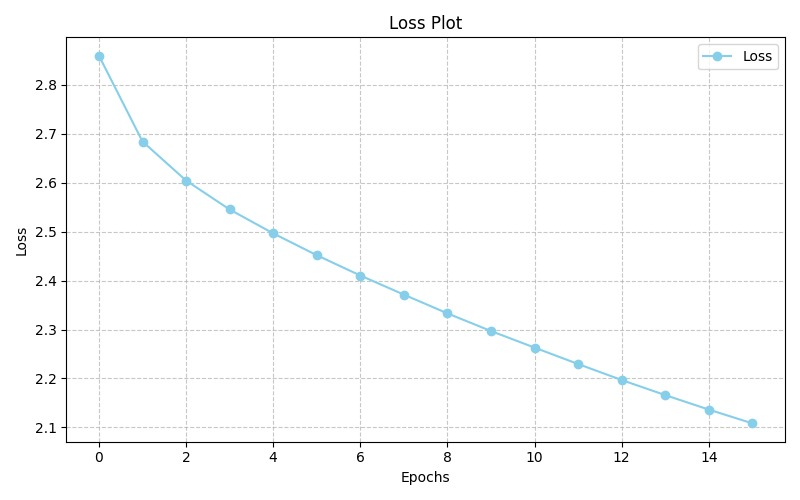

In [12]:
from IPython.display import Image
Image("/content/loss graph.jpg")

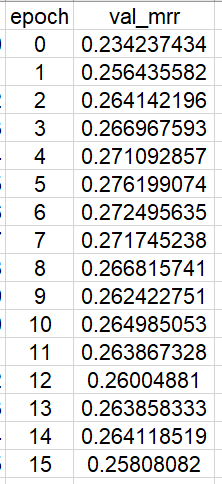

In [13]:
Image("/content/epoch performance.png")

## Creating submission

To create the submission file, we recommended the top 10 reviews for each user within the same accommodation.

These reviews were selected by calculating the dot product between their embeddings and the user's embedding, then choosing the 10 with the highest similarity scores.

In [ ]:
# Load data
data_dir = "/content/processed/"
users_df = pd.read_csv(data_dir + "test_users.csv")
users_df = users_df[['user_id', 'accommodation_id', 'user_context']]

reviews_df = pd.read_csv(data_dir + "test_reviews.csv")
reviews_df = reviews_df[['review_id', 'accommodation_id', 'review_context']]

# Initialize models
save_models_dir = "/content/models/"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_model = 'sentence-transformers/all-MiniLM-L6-v2'

# Load user embedding model
user_embedding_model = AutoModel.from_pretrained(embedding_model).to(device)
state_dict = torch.load(save_models_dir + "Epoch_5_user_embedding_model.pth")
new_state_dict = {k.replace("model.", ""): v for k, v in state_dict.items()}
user_embedding_model.load_state_dict(new_state_dict)

# Load review embedding model
review_embedding_model = AutoModel.from_pretrained(embedding_model).to(device)
state_dict = torch.load(save_models_dir + "Epoch_5_review_embedding_model.pth")
new_state_dict = {k.replace("model.", ""): v for k, v in state_dict.items()}
review_embedding_model.load_state_dict(new_state_dict)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(embedding_model)

# Prepare submission dataframe
submission = []

# Predict top 10 reviews for each user
user_embedding_model.eval()
review_embedding_model.eval()

with torch.no_grad():
    for idx, row in users_df.iterrows():
        # Encode user context
        user_encoding = tokenizer([row['user_context']], padding=True, truncation=True, return_tensors='pt')
        user_embedding = user_embedding_model(**user_encoding.to(device)).last_hidden_state[:, 0, :]

        # Filter reviews for the user's accommodation
        reviews_data = reviews_df[reviews_df['accommodation_id'] == row['accommodation_id']]

        # Encode reviews
        review_encodings = tokenizer(reviews_data['review_context'].tolist(), padding=True, truncation=True, return_tensors='pt')
        review_embeddings = review_embedding_model(**review_encodings.to(device)).last_hidden_state[:, 0, :]

        # Compute similarity and get top 10 reviews
        similarity_matrix = user_embedding @ review_embeddings.T  # Shape: (1, num_reviews)
        top_10_indices = similarity_matrix.squeeze(0).topk(10).indices.tolist()
        top_10_review_ids = reviews_data.iloc[top_10_indices]['review_id'].tolist()

        # Add to submission
        submission.append({
            'ID': len(submission) + 1,
            'accommodation_id': accommodation_id,
            'user_id': row['user_id'],
            **{f'review_{i + 1}': top_10_review_ids[i] for i in range(10)}
        })


# Save submission to a CSV file
submission_df = pd.DataFrame(submission)
submission_file = "/content/submission.csv"
submission_df.to_csv(submission_file, index=False)

print(f"Submission file saved to {submission_file}")